# Test of the method with direct calculation of vertical actions 

This notebook compares the prediction of the analytic model with exact numerical integration of test particles to compute the change in the vertical action. 

In [ ]:
import numpy as np 

import matplotlib.pyplot as plt

import astropy.units as apu 

from darkspirals.disc import Disc
from darkspirals.orbit_util import integrate_single_orbit, sample_sag_orbit, satellite_vertical_force
from galpy.potential import MovingObjectPotential, turn_physical_off
from darkspirals.substructure.realization import SubstructureRealization
from darkspirals.distribution_function.compute_df import compute_df_from_actions


import galpy 
from galpy.orbit import Orbit
from galpy.actionAngle.actionAngleVertical import actionAngleVertical
from galpy.potential import evaluatezforces, NFWPotential
from galpy.potential import toVerticalPotential
from galpy.potential import MWPotential2014
from galpy.potential import SolidBodyRotationWrapperPotential 

from scipy.integrate import simpson

plt.rcParams['axes.linewidth'] = 2.
plt.rcParams['xtick.major.width'] = 2.
plt.rcParams['xtick.major.size'] = 6
plt.rcParams['xtick.minor.width'] = 1.0
plt.rcParams['xtick.minor.size'] = 3.5
plt.rcParams['ytick.major.width'] = 2.0
plt.rcParams['ytick.major.size'] = 6
plt.rcParams['ytick.minor.width'] = 1.0
plt.rcParams['ytick.minor.size'] = 3.5
plt.rcParams.update({'font.size': 16})

In [3]:
z_min_max = 1.5 
vz_min_max = 100 
phase_space_resolution = 100
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 1000) * apu.Gyr

disc = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
            time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True, r_over_r0=1.0)

### set up perturber orbits

In [4]:
np.random.seed(11)
realization = SubstructureRealization.withDistanceCut(disc, norm=2500, r_min=30, 
                                                      num_halos_scale=1.0, 
                                                      m_low=10**7.0, 
                                                      m_high=10**8.0)
realization.add_dwarf_galaxies(add_orbit_uncertainties=True, 
                               tidal_stripping=False,
                                       include_dwarf_list=['Tucana III', 'Sagittarius'], 
                               log10_dsphr_masses={'Tucana III': 8, 'Sagittarius': 9})

f = 0
for i in range(0, len(realization.orbits)):    
    f += realization.orbits[i].force_exerted(disc, physical_units=True) 
delta_v = simpson(np.absolute(f), x=disc.time_internal_eval)
print('delta v: ', delta_v)
print(realization.orbits[0].vxvv)

vcirc = galpy.potential.vcirc(disc.galactic_potential, disc.r_over_r0)
circ_freq_solar_orbit = vcirc / disc.r_over_r0
# exact_potential = MWPotential2014 + \
#     SolidBodyRotationWrapperPotential(pot=MovingObjectPotential(perturber_orbit, 
#                                                           pot=perturber_potential),
#                                         omega=-circ_freq_solar_orbit)

exact_potential = MWPotential2014
for perturber_orbit, perturber_potential in zip(realization.orbits, realization.potentials):
    exact_potential += SolidBodyRotationWrapperPotential(pot=MovingObjectPotential(perturber_orbit, 
                                                          pot=perturber_potential), omega=-circ_freq_solar_orbit)
exact_potential_vertical = toVerticalPotential(exact_potential,
                                                disc.r_over_r0, phi=0)
turn_physical_off(exact_potential_vertical)
equilibrium_potential_vertical = toVerticalPotential(MWPotential2014, disc.r_over_r0)
turn_physical_off(equilibrium_potential_vertical)

delta v:  -3.8717379732378334
[[12.73149397  0.34643708  0.13774952  2.68888503  0.41047702 -1.98434213]]


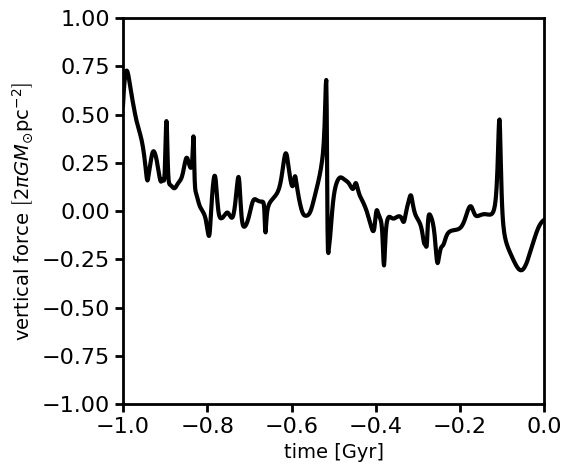

In [27]:
fig = plt.figure()
fig.set_size_inches(6,5)
ax = plt.subplot(111)
ax.plot(time_Gyr, f, color='k', lw=3)
ax.set_ylabel('vertical force '+r'$\left[2 \pi G M_{\odot} \rm{pc^{-2}}\right]$', fontsize=14)
ax.set_xlabel('time [Gyr]', fontsize=14)
ax.set_ylim(-1, 1)
ax.set_xlim(-1, 0)
plt.tight_layout()
plt.savefig('../notebooks/figures/force_test.pdf')

### Do the exact calculation 

In [6]:
ro = 8.0
vo = 220.0
coordinates = np.array(np.meshgrid(disc.z_units_internal, disc.vz_units_internal)).T

idx1, idx2 = 68, 40
z_internal, vz_internal = coordinates[idx1,idx2,:]
z_phys, vz_phys = z_internal * ro, vz_internal * vo
print('coordinates: ', z_phys, vz_phys)

initial_action, intial_angle, intial_freq = disc.action_angle_interp((z_phys, vz_phys))
print('intial action/angle/freq: ', initial_action, intial_angle, intial_freq)

coordinates:  0.5606060606060606 -19.191919191919183
intial action/angle/freq:  0.007104617779255529 2.1906859023262695 1.9262826554705177


In [7]:
perturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
perturbed_orbit.integrate(disc.time_internal_eval, pot=exact_potential_vertical)

unperturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
unperturbed_orbit.integrate(disc.time_internal_eval, pot=equilibrium_potential_vertical)

aav = actionAngleVertical(pot=equilibrium_potential_vertical)
jz_true, freq_true, theta_true = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval), 
                                               perturbed_orbit.vx(disc.time_internal_eval))

jz_eq, freq_eq, theta_eq = aav.actionsFreqsAngles(unperturbed_orbit.x(disc.time_internal_eval), 
                                               unperturbed_orbit.vx(disc.time_internal_eval))
deltaJ_true = jz_true[-1] - jz_true[0]

/Users/danielgilman/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleVertical.py:258: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  angle[ii] = integrate.quad(



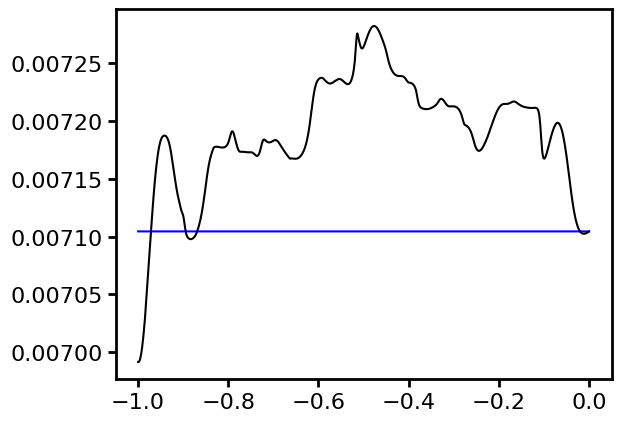

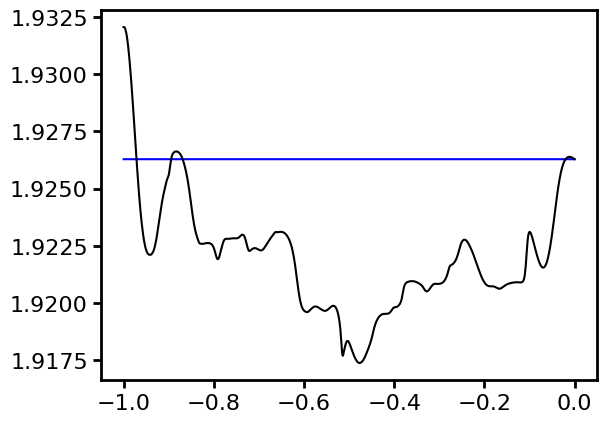

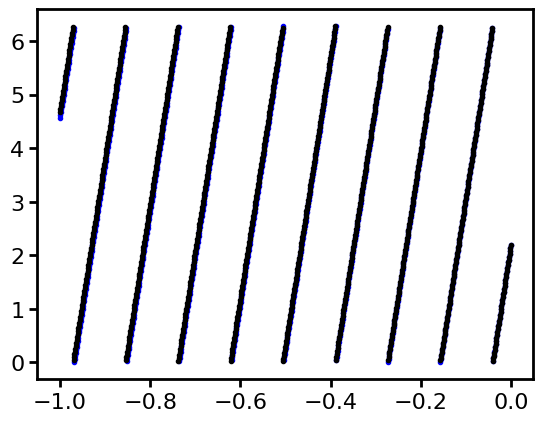

In [8]:
plt.plot(time_Gyr, jz_eq, color='b')
plt.plot(time_Gyr, jz_true, color='k')
plt.show()

plt.plot(time_Gyr, freq_eq, color='b')
plt.plot(time_Gyr, freq_true, color='k'); plt.show()

plt.plot(time_Gyr, theta_eq, '.', color='b')
plt.plot(time_Gyr, theta_true, '.', color='k'); plt.show()

### Compare results

In [9]:
x_solar = disc.r_over_r0 * np.cos(circ_freq_solar_orbit * disc.time_internal_eval)
y_solar = disc.r_over_r0 * np.sin(circ_freq_solar_orbit * disc.time_internal_eval)
z_coord = unperturbed_orbit.x(disc.time_internal_eval)

force = 0
deltaJ_approx = 0
for perturber_orbit, perturber_potential in zip(realization.orbits, realization.potentials):
    
    dx = x_solar - perturber_orbit.x(disc.time_internal_eval)
    dy = y_solar - perturber_orbit.y(disc.time_internal_eval)
    dz = z_coord - perturber_orbit.z(disc.time_internal_eval)
    dR = np.sqrt(dx ** 2. + dy ** 2.)
    turn_physical_off(perturber_potential)
    force = evaluatezforces(perturber_potential, R=dR, z=dz)
    integrand = force * unperturbed_orbit.vx(disc.time_internal_eval) / intial_freq
    deltaJ_approx += simpson(integrand, disc.time_internal_eval)

print('approx: ', 10000*deltaJ_approx)
print('exact (x10000): ', 10000*deltaJ_true)
print('difference %: ', 100*(deltaJ_approx/deltaJ_true-1))

approx:  -1.046046212515161
exact (x10000):  -1.1306144696254448
difference %:  -7.479849177792664


### Do the calculation for many samples in (z, vz)

In [19]:
deltaJ_true = []
deltaJ_approx = []
z_coords = []
vz_coords = []
jz_initial = []
turn_physical_off(perturber_potential)
ro = 8.0
vo = 220.0

df_eq = compute_df_from_actions(disc, 15.2, 0.0, df_model='LI&WIDROW')
aav = actionAngleVertical(pot=equilibrium_potential_vertical)

for _ in range(0, 1000):
    
    #(z_phys, vz_phys) = df_eq.sample(1)
    z_phys = np.random.uniform(-1.5, 1.5)
    vz_phys = np.random.uniform(-100, 100)
    z_internal = z_phys / ro
    vz_internal = vz_phys / vo
    z_coords.append(z_phys)
    vz_coords.append(vz_phys)
    
    perturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
    perturbed_orbit.integrate(disc.time_internal_eval, pot=exact_potential_vertical)

    jz_t0, _, _ = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval[0]), 
                                                   perturbed_orbit.vx(disc.time_internal_eval[0]))
    jz_tf, _, _ = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval[-1]), 
                                                   perturbed_orbit.vx(disc.time_internal_eval[-1]))
    deltaJ_true.append(jz_tf[0] - jz_t0[0])
    jz_initial.append(initial_action)
    
    unperturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
    unperturbed_orbit.integrate(disc.time_internal_eval, pot=equilibrium_potential_vertical)
    z_coord = unperturbed_orbit.x(disc.time_internal_eval)
    approx = 0

    _, _, intial_freq = disc.action_angle_interp((z_phys, vz_phys))
    for perturber_orbit, perturber_potential in zip(realization.orbits, realization.potentials):
    
        dx = x_solar - perturber_orbit.x(disc.time_internal_eval)
        dy = y_solar - perturber_orbit.y(disc.time_internal_eval)
        dz = z_coord - perturber_orbit.z(disc.time_internal_eval)
        dR = np.sqrt(dx ** 2. + dy ** 2.)
        turn_physical_off(perturber_potential)
        force = evaluatezforces(perturber_potential, R=dR, z=dz)
        integrand = force * unperturbed_orbit.vx(disc.time_internal_eval) / intial_freq
        approx += simpson(integrand, disc.time_internal_eval)
    
    deltaJ_approx.append(approx)

/Users/danielgilman/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleVertical.py:258: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  angle[ii] = integrate.quad(



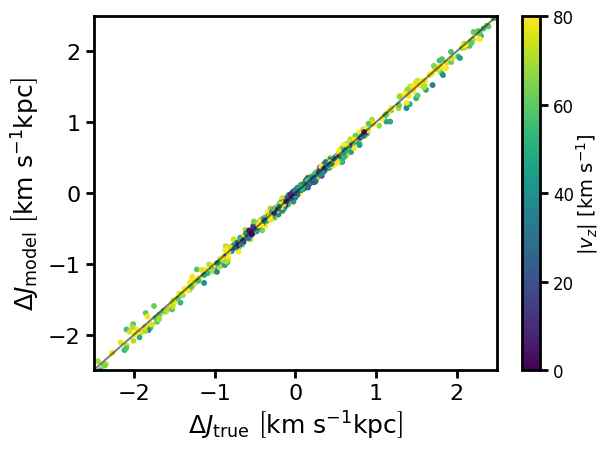

2.7593444726767196
2.7593444726767196


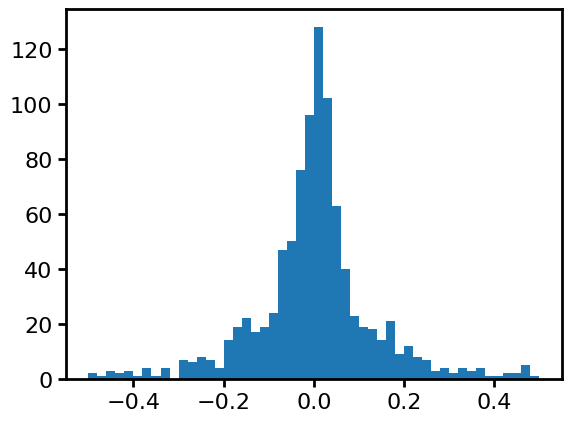

In [55]:
import matplotlib as mpl
from scipy.interpolate import interp1d

cmap = mpl.colormaps['viridis']

# colors = np.squeeze(np.absolute(z_coords))
# colors[np.where(colors > 1.5)] = 1.5
# cbar_scale = np.linspace(0, 1.5, 100)
# cbar_scale_eval = interp1d(cbar_scale, np.linspace(0, 1, 100))
# colors = cbar_scale_eval(colors)

colors = np.squeeze(np.absolute(vz_coords))
colors[np.where(colors > 80.0)] = 80.0
cbar_scale = np.linspace(0, 80, 100)
cbar_scale_eval = interp1d(cbar_scale, np.linspace(0, 1, 100))
colors = cbar_scale_eval(colors)

deltaJ_true = np.array(deltaJ_true) 
deltaJ_approx = np.array(deltaJ_approx)
error = deltaJ_approx - deltaJ_true
error_abs_rel = np.absolute(deltaJ_approx - deltaJ_true) / np.array(jz_initial)
error_rel = error / np.array(jz_initial)

plt.figure()
ax = plt.subplot(111)
im =ax.scatter(deltaJ_true * 8*220, deltaJ_approx * 8 * 220, c=colors,s=10,alpha=1.)
cbar = plt.colorbar(im,cmap=cmap,label=r'$v_z$')
cbar.set_label(r'$|v_z| \ \left[\rm{km} \ \rm{s^{-1}}\right]$', fontsize=14, rotation=90, labelpad=0)
cbar.set_ticks([0.0, 0.25, 0.5, 0.75, 1.0])
cbar.set_ticklabels([0, 20, 40, 60, 80], fontsize=12)
ax.plot(np.linspace(-10, 10, 100), np.linspace(-10, 10, 100), color='k',alpha=0.5)
ax_minmax = 2.5
ax.set_xlim(-ax_minmax, ax_minmax)
ax.set_ylim(-ax_minmax, ax_minmax)
ax.set_xticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_yticks([-2.0, -1.0, 0.0, 1.0, 2.0])
ax.set_xlabel(r'$\Delta J_{\rm{true}} \ \left[\rm{km} \ \rm{s^{-1}} \rm{kpc}\right]$', fontsize=18)
ax.set_ylabel(r'$\Delta J_{\rm{model}}\ \left[\rm{km} \ \rm{s^{-1}} \rm{kpc}\right]$', fontsize=18)
plt.tight_layout()
plt.savefig('../notebooks/figures/deltaJ_test.pdf')
plt.show()

plt.figure()
error = np.array(deltaJ_approx/deltaJ_true)-1
_ = plt.hist(error,bins=50,range=(-0.5, 0.5))
print(np.std(error))
print(np.std(error))

In [12]:
z_min_max = 1.5 
vz_min_max = 100 
phase_space_resolution = 60
z = np.linspace(-z_min_max,z_min_max,phase_space_resolution)
vz = np.linspace(-vz_min_max, vz_min_max, phase_space_resolution)
galactic_potential = MWPotential2014
time_Gyr = np.linspace(0.0, -1., 1000) * apu.Gyr

disc_lowres = Disc(galactic_potential, galactic_potential, z_min_max, vz_min_max, phase_space_resolution, 
            time_Gyr, parallelize_action_angle_computation=True, compute_upfront=True, r_over_r0=1.0)

In [13]:
from darkspirals.distribution_function.compute_df import compute_df_from_actions

deltaJ_true_grid = []
deltaJ_approx_grid = []
z_coords_grid = []
vz_coords_grid = []

ro = 8.0
vo = 220.0

df_eq = compute_df_from_actions(disc, 15.2, 0.0, df_model='LI&WIDROW')
aav = actionAngleVertical(pot=equilibrium_potential_vertical)

vxvv = np.array(np.meshgrid(disc_lowres.z_units_internal, disc_lowres.vz_units_internal)).T
zz = vxvv[:, :, 0].ravel()
vzvz = vxvv[:, :, 1].ravel()

for i in range(0, len(zz)):
    
    #(z_phys, vz_phys) = df_eq.sample(1)
    z_phys = zz[i] * ro
    vz_phys = vzvz[i] * vo
    z_internal = zz[i]
    vz_internal =  vzvz[i]
    z_coords.append(z_phys)
    vz_coords.append(vz_phys)
    
    perturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
    perturbed_orbit.integrate(disc.time_internal_eval, pot=exact_potential_vertical)
    
    jz_t0, _, _ = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval[0]), 
                                                   perturbed_orbit.vx(disc.time_internal_eval[0]))
    jz_tf, _, _ = aav.actionsFreqsAngles(perturbed_orbit.x(disc.time_internal_eval[-1]), 
                                                   perturbed_orbit.vx(disc.time_internal_eval[-1]))
    
    deltaJ_true_grid.append(jz_tf[0] - jz_t0[0])
    
    unperturbed_orbit = Orbit(vxvv=[z_internal, vz_internal])
    unperturbed_orbit.integrate(disc.time_internal_eval, pot=equilibrium_potential_vertical)
    z_coord = unperturbed_orbit.x(disc.time_internal_eval)
    approx = 0
    for perturber_orbit, perturber_potential in zip(realization.orbits, realization.potentials):
    
        dx = x_solar - perturber_orbit.x(disc.time_internal_eval)
        dy = y_solar - perturber_orbit.y(disc.time_internal_eval)
        dz = z_coord - perturber_orbit.z(disc.time_internal_eval)
        dR = np.sqrt(dx ** 2. + dy ** 2.)
        turn_physical_off(perturber_potential)
        force = evaluatezforces(perturber_potential, R=dR, z=dz)
        integrand = force * unperturbed_orbit.vx(disc.time_internal_eval) / intial_freq
        approx += simpson(integrand, disc.time_internal_eval)
    
    deltaJ_approx_grid.append(approx)

deltaJ_approx_grid = np.array(deltaJ_approx_grid).reshape(phase_space_resolution,phase_space_resolution)
deltaJ_true_grid = np.array(deltaJ_true_grid).reshape(phase_space_resolution,phase_space_resolution)

for orb in realization.orbits:
    orb.force_array_computed = False

forces_code = disc_lowres.compute_satellite_forces(satellite_orbit_list=realization.orbits,
                                 satellite_potentials_list=realization.potentials)[0]

deltaJ_code = disc_lowres.compute_deltaJ_from_forces(forces_code)

/Users/danielgilman/anaconda3/lib/python3.8/site-packages/galpy/actionAngle/actionAngleVertical.py:258: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  angle[ii] = integrate.quad(



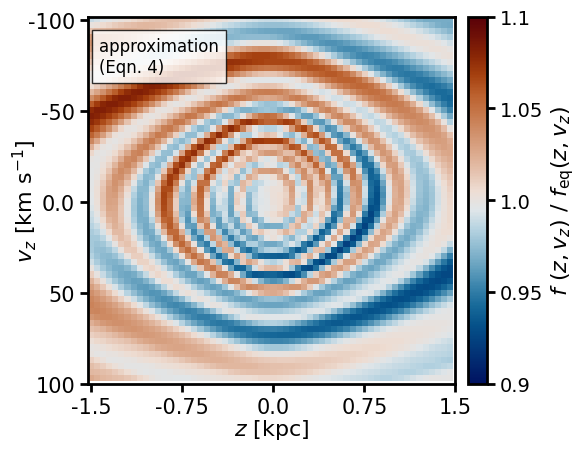

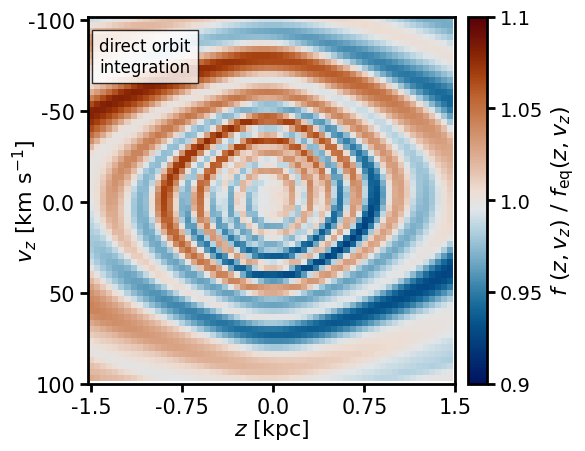

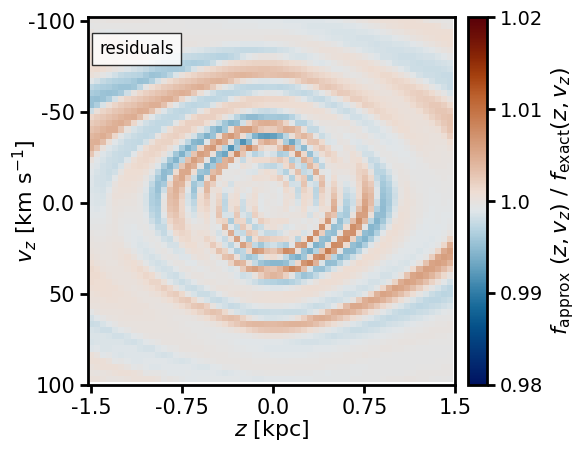

In [17]:
from palettable.scientific.diverging import Vik_20 as cmap
cmap = cmap.get_mpl_colormap()

velocity_disp = 15.2
df_perturbed_approx = compute_df_from_actions(disc_lowres, velocity_disp, deltaJ_approx_grid,
                                             df_model='LI&WIDROW')
df_perturbed_code = compute_df_from_actions(disc_lowres, velocity_disp, deltaJ_code,
                                             df_model='LI&WIDROW')
df_perturbed_exact = compute_df_from_actions(disc_lowres, velocity_disp, deltaJ_true_grid,
                                            df_model='LI&WIDROW')
df_eq = compute_df_from_actions(disc_lowres, velocity_disp, 0.0,
                                            df_model='LI&WIDROW')

fig = plt.figure(1)
#fig.set_size_inches(6,5)
ax = plt.subplot(111)
vminmax = 0.1
label = 'approximation\n(Eqn. 4)'
cbar_ticks = np.round(np.linspace(1-vminmax, 1+vminmax, 5),2)
im = ax.imshow(np.rot90(df_perturbed_code.function/df_eq.function), origin='upper', vmin=1-vminmax, vmax=1.+vminmax,cmap=cmap) 
ax.annotate(label, xy=(0.03, 0.85), xycoords='axes fraction',
           bbox=dict(facecolor='w', edgecolor='k', pad=5.0,alpha=0.8), fontsize=12)
cbar = plt.colorbar(im, ax=ax, pad=0.025)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'$f \ \left(z, v_z\right) \ / \ f_{\rm{eq}}\left(z, v_z\right)$')
zticks = [-1.5, -0.75, 0.0, 0.75, 1.5]
vzticks = [-100, -50, 0.0, 50, 100]
ax.set_xticks(np.linspace(0, 60, 5))
ax.set_yticks(np.linspace(0, 60, 5))
ax.set_xticklabels(zticks, fontsize=15)
ax.set_yticklabels(vzticks, fontsize=15)
ax.set_xlabel(r'$z \ \left[\rm{kpc}\right]$', fontsize=16,labelpad=-0)
ax.set_ylabel(r'$v_z \ \left[ \rm{km} \ \rm{s^{-1}}\right]$', fontsize=16, labelpad=-8)
plt.tight_layout()
plt.savefig('../notebooks/figures/df_figures/test_code_result.pdf')
plt.show()

fig = plt.figure(2)
#fig.set_size_inches(6,5)
ax = plt.subplot(111)
vminmax = 0.1
label = 'direct orbit\nintegration'
cbar_ticks = np.round(np.linspace(1-vminmax, 1+vminmax, 5),2)
im = ax.imshow(np.rot90(df_perturbed_exact.function/df_eq.function), origin='upper', vmin=1-vminmax, vmax=1.+vminmax,cmap=cmap) 
ax.annotate(label, xy=(0.03, 0.85), xycoords='axes fraction',
           bbox=dict(facecolor='w', edgecolor='k', pad=5.0,alpha=0.8), fontsize=12)
cbar = plt.colorbar(im, ax=ax, pad=0.025)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'$f \ \left(z, v_z\right) \ / \ f_{\rm{eq}}\left(z, v_z\right)$')
zticks = [-1.5, -0.75, 0.0, 0.75, 1.5]
vzticks = [-100, -50, 0.0, 50, 100]
ax.set_xticks(np.linspace(0, 60, 5))
ax.set_yticks(np.linspace(0, 60, 5))
ax.set_xticklabels(zticks, fontsize=15)
ax.set_yticklabels(vzticks, fontsize=15)
ax.set_xlabel(r'$z \ \left[\rm{kpc}\right]$', fontsize=16,labelpad=-0)
ax.set_ylabel(r'$v_z \ \left[ \rm{km} \ \rm{s^{-1}}\right]$', fontsize=16, labelpad=-8)
plt.tight_layout()
plt.savefig('../notebooks/figures/df_figures/test_exact_result.pdf')
plt.show()

fig = plt.figure(3)
#fig.set_size_inches(6,5)
ax = plt.subplot(111)
vminmax = 0.02

label = 'residuals'
cbar_ticks = np.round(np.linspace(1-vminmax, 1+vminmax, 5),3)
im = ax.imshow(np.rot90(df_perturbed_code.function/df_perturbed_exact.function), origin='upper', vmin=1-vminmax, vmax=1.+vminmax,cmap=cmap) 
ax.annotate(label, xy=(0.03, 0.9), xycoords='axes fraction',
           bbox=dict(facecolor='w', edgecolor='k', pad=5.0,alpha=0.8), fontsize=12)
cbar = plt.colorbar(im, ax=ax, pad=0.025)
cbar.set_ticks(cbar_ticks)
cbar.set_ticklabels(cbar_ticks)
cbar.ax.tick_params(labelsize=14) 
cbar.set_label(r'$f_{\rm{approx}} \ \left(z, v_z\right) \ / \ f_{\rm{exact}}\left(z, v_z\right)$')
zticks = [-1.5, -0.75, 0.0, 0.75, 1.5]
vzticks = [-100, -50, 0.0, 50, 100]
ax.set_xticks(np.linspace(0, 60, 5))
ax.set_yticks(np.linspace(0, 60, 5))
ax.set_xticklabels(zticks, fontsize=15)
ax.set_yticklabels(vzticks, fontsize=15)
ax.set_xlabel(r'$z \ \left[\rm{kpc}\right]$', fontsize=16,labelpad=-0)
ax.set_ylabel(r'$v_z \ \left[ \rm{km} \ \rm{s^{-1}}\right]$', fontsize=16, labelpad=-8)
plt.tight_layout()
plt.savefig('../notebooks/figures/df_figures/test_residuals.pdf')
plt.show()